## stimulus generation

In [1]:
import numpy as np
from rgc_natstim_model.utils.data_handling import unPickle,makePickle
from rgc_natstim_model.utils.nm_vis import img_real2view,get_rectangle_corners, downSample 
import cv2
import matplotlib.pyplot as plt

In [2]:
data_path = '/gpfs01/euler/data/SharedFiles/projects/Hoefling2024/data/simulation/stim_gen/'

In [3]:
selected_movie_frames = np.load(data_path+'selected_movie_frames.npy')
selected_horizon_prediction = np.load(data_path+'selected_horizon_prediction.npy')

### below are the movie data used for generate stimulus for in silico experiment

In [4]:
print(selected_movie_frames.shape)
## numFrame, x_pix, y_pix, UV-G-0 channels
print(selected_horizon_prediction.shape)
## numFrame, 15 predicted Horizon spots, (x_coor,y_coor,prediction)

(500, 437, 437, 3)
(500, 15, 3)


### visualize

In [5]:
## define the four corners of the moving trajectory
up_left = (100,100)
up_right = (320,100)
down_left = (100,320)
down_right = (320,320)

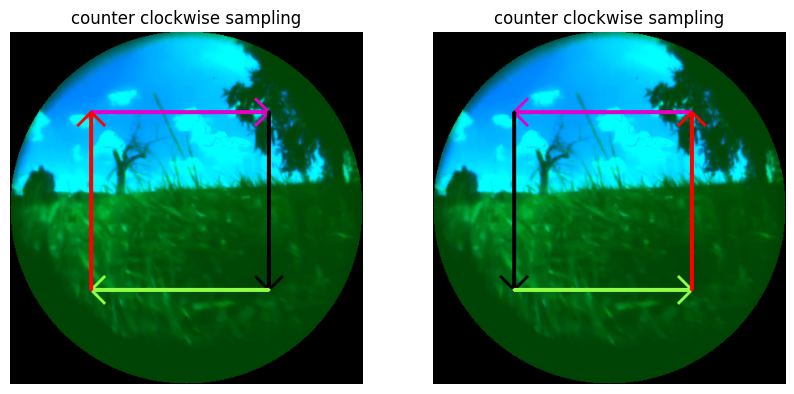

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5),facecolor='white')
for i in range(len(selected_movie_frames)):
    horizon_xys = selected_horizon_prediction[i,:,:2]
    
    trace = np.copy(selected_movie_frames[i])
    R_trace = np.copy(selected_movie_frames[i])
    ## visualize the clock-wise sampling
    # cv2.rectangle(trace,up_left,down_right,color = (255,255,255),thickness=2)
    cv2.arrowedLine(trace,up_left,up_right,color = (200,0,200),thickness = 3)
    cv2.arrowedLine(trace,up_right,down_right,color = (0,0,0),thickness = 3)
    cv2.arrowedLine(trace,down_right,down_left,color = (70,255,70),thickness = 3)
    cv2.arrowedLine(trace,down_left,up_left,color = (0,0,255),thickness = 3)
    
    ax[0].imshow(img_real2view(trace[...,::-1]))
    ax[0].set_title('counter clockwise sampling')
    ax[0].axis('off')
    
    ## visualize the counter-clock-wise sampling
    cv2.arrowedLine(R_trace,up_right,up_left,color = (200,0,200),thickness = 3)
    cv2.arrowedLine(R_trace,up_left,down_left,color = (0,0,0),thickness = 3)
    cv2.arrowedLine(R_trace,down_left,down_right,color = (70,255,70),thickness = 3)
    cv2.arrowedLine(R_trace,down_right,up_right,color = (0,0,255),thickness = 3)
    ax[1].imshow(img_real2view(R_trace[...,::-1]))
    ax[1].set_title('counter clockwise sampling')
    ax[1].axis('off')
    break  

In [7]:
# np.save('/gpfs01/euler/User/ydeng/data_LH/selected_horizon_prediction.npy',selected_horizon_prediction)

### sample the selected frames for 4 different speeds

In [8]:
speeds = [4,12,20,28] # unit: pxl jump per sample

In [9]:
## quick demo
speeds=[4]

In [10]:
speeds_pos = unPickle(data_path+'speed4122028_posDict.pkl')
R_speed_pos = unPickle(data_path+'R_speed4122028_posDict.pkl')

In [11]:
for speed in speeds:
    pos = speeds_pos[speed] # a list of x-y coordinates
    r_pos = R_speed_pos[speed]
    
    s_ds_output = np.zeros((len(selected_movie_frames),2,len(pos),18,16)) # numFrame, color, length,18 16
    R_ds_output = np.zeros((len(selected_movie_frames),2,len(r_pos),18,16)) # numFrame, color, length,18 16
    
    for ff, frame in enumerate(selected_movie_frames):
        print('for frame no.{}'.format(ff))
        # for each selected frame /500
        # clockwise
        output = np.zeros((len(pos),72,64,3))
        ds_output = np.zeros((len(output),2,18,16))
        
        for pp in range(len(pos)):
            ## for each crop's center coordinate
            crop_points = get_rectangle_corners(pos[pp])
            h_top_left,v_top_left = crop_points[0]
            # print(h_top_left,v_top_left)
            ## take a crop at each position /224 for speed4
            crop = np.copy(frame)[v_top_left:v_top_left+72,h_top_left:h_top_left+64,:]
            
            output[pp] = np.copy(crop)
            ds_output[pp,0] = downSample(np.copy(crop)[:,:,1])
            ds_output[pp,1] = downSample(np.copy(crop)[:,:,0])
            if pp == len(pos)-1:
                print('done clockwise')
        ds_output = ds_output.transpose((1,0,2,3)).reshape((1,2,max(ds_output.shape),18,16))
        s_ds_output[ff] = np.copy(ds_output)
        
        ## counter-clockwise
        output = np.zeros((len(r_pos),72,64,3))
        ds_output = np.zeros((len(r_pos),2,18,16))
        for pp in range(len(r_pos)):
            ## for each crop's center coordinate
            
            crop_points = get_rectangle_corners(r_pos[pp])
            h_top_left,v_top_left = crop_points[0]
            # print(h_top_left,v_top_left)
            ## take a crop at each position /224 for speed4
            crop = np.copy(frame)[v_top_left:v_top_left+72,h_top_left:h_top_left+64,:]
            
            output[pp] = np.copy(crop)
            ds_output[pp,0] = downSample(np.copy(crop)[:,:,1])
            ds_output[pp,1] = downSample(np.copy(crop)[:,:,0])
            if pp == len(r_pos)-1:
                print("counter clockwise done")
        ds_output = ds_output.transpose((1,0,2,3)).reshape((1,2,max(ds_output.shape),18,16))
        R_ds_output[ff] = np.copy(ds_output)
        
    # np.save("/gpfs01/euler/User/ydeng/data_LH/sti500_s{}_18x16.npy".format(speed),s_ds_output)
    # np.save("/gpfs01/euler/User/ydeng/data_LH/R_sti500_s{}_18x16.npy".format(speed),R_ds_output)

for frame no.0
done clockwise
counter clockwise done
for frame no.1
done clockwise
counter clockwise done
for frame no.2
done clockwise
counter clockwise done
for frame no.3
done clockwise
counter clockwise done
for frame no.4
done clockwise
counter clockwise done
for frame no.5
done clockwise
counter clockwise done
for frame no.6
done clockwise
counter clockwise done
for frame no.7
done clockwise
counter clockwise done
for frame no.8
done clockwise
counter clockwise done
for frame no.9
done clockwise
counter clockwise done
for frame no.10
done clockwise
counter clockwise done
for frame no.11
done clockwise
counter clockwise done
for frame no.12
done clockwise
counter clockwise done
for frame no.13
done clockwise
counter clockwise done
for frame no.14
done clockwise
counter clockwise done
for frame no.15
done clockwise
counter clockwise done
for frame no.16
done clockwise
counter clockwise done
for frame no.17
done clockwise
counter clockwise done
for frame no.18
done clockwise
counter

#### intermeidate output before add gray padding

In [12]:
for speed in speeds:
    print(speed)
    snippet_len = len(speeds_pos[speed])//4
    output = np.zeros((1000,2,len(speeds_pos[speed]),18,16))
    
    ## clockwise
    output[:500] = np.load(data_path+'sti500_s{}_18x16.npy'.format(speed))
    
    ## counter-clockwise
    output[500:] = np.load(data_path+'R_sti500_s{}_18x16.npy'.format(speed))
    
    
    ## split it into 4 transition
    ## make it suitable for generate model responses
    output = output.reshape((1000,2,4,snippet_len,18,16)).transpose((0,2,1,3,4,5))
    
    
    ## turn variable-length snippets into 120-f
    input_for120f = output.reshape((4000,2,snippet_len,18,16))
    # np.save('/gpfs01/euler/User/ydeng/data_LH/sti1000_{}f_s{}_18x16.npy'.format(snippet_len,speed),input_for120f)

4


In [13]:
input_for120f.shape

(4000, 2, 56, 18, 16)

### quick demo for speed 4 (50 degree/s)

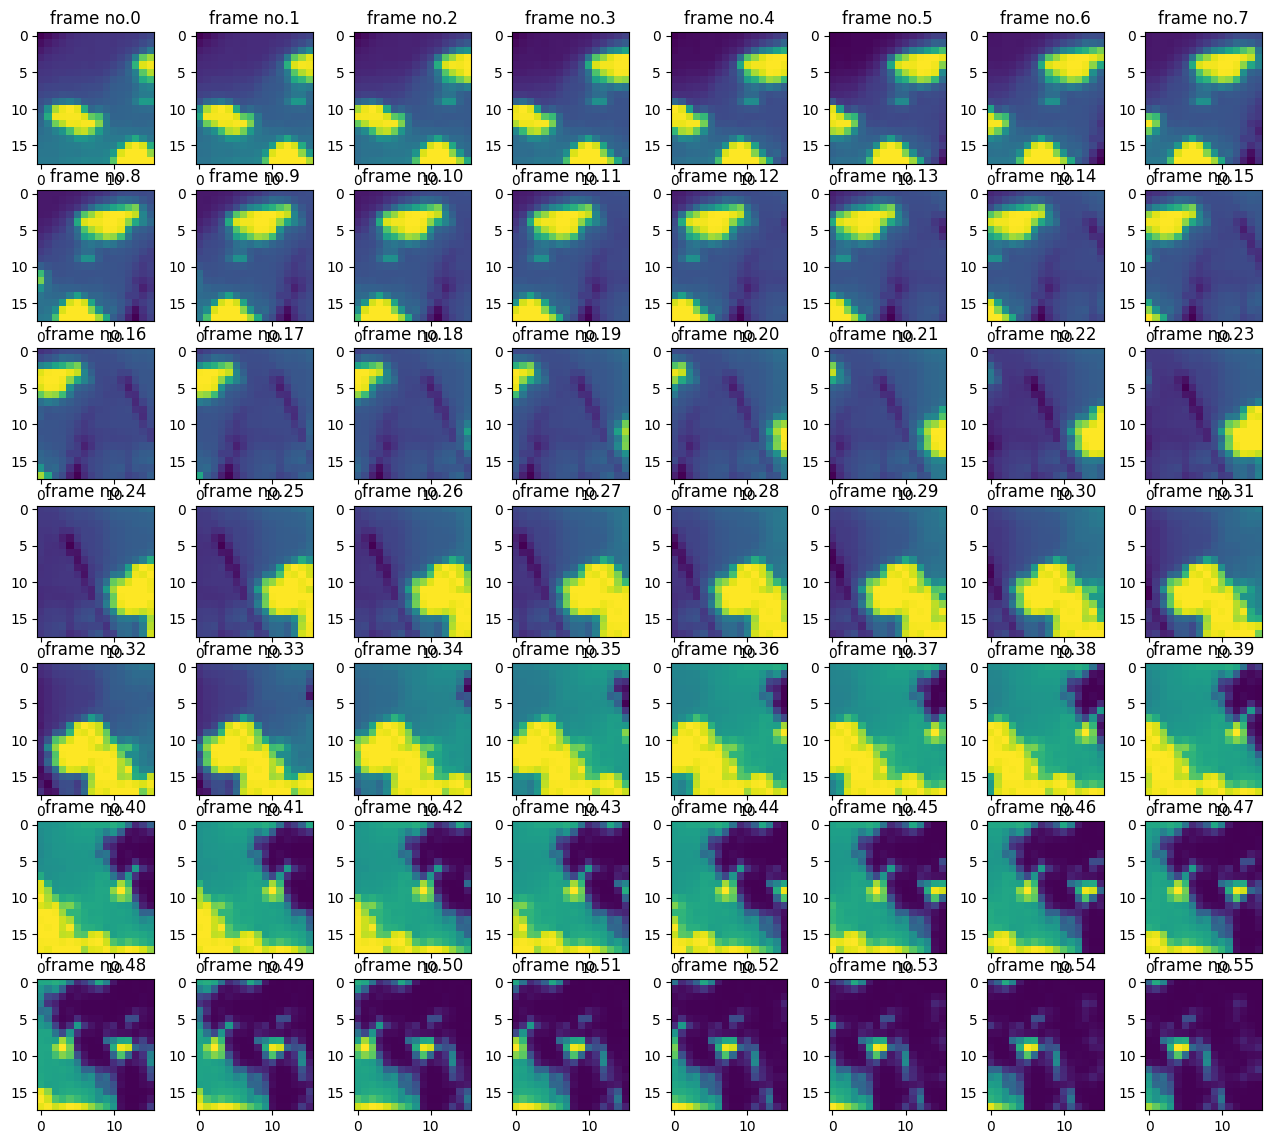

In [14]:
fig,ax= plt.subplots(7,8,figsize=(16,14))
ax=ax.flatten()
for i in range(56):
    ax[i].imshow(input_for120f[0,0,i])
    ax[i].set_title('frame no.{}'.format(i))

### add gray padding frames and repeat the first & the last moving frame to fill up the middle 60f snippet

In [15]:
speed2snippetLen = unPickle(data_path+'speed2snippetLen.pkl')
speed2embbedingidx= unPickle(data_path+'speed2embbedingidx.pkl')

In [16]:
for speed in speeds:
    origin_sti = np.load(data_path+'sti1000_{}f_s{}_18x16.npy'.format(speed2snippetLen[speed],speed))
    
    len_tt = speed2snippetLen[speed]
    output = np.zeros((4*1000,2,120,18,16))
    indx1 = speed2embbedingidx[speed][0]
    indx2 = speed2embbedingidx[speed][1]
    
    print(origin_sti.shape)
    output[:,:,:30,:,:]=128
    output[:,:,-30:,:,:]=128
    for snip in range(4000):
        orig = origin_sti[snip] # 2,56,18,16
        # print(orig.shape)
        for beg in range(30,indx1+30):
            # print(beg)
            output[snip,:,beg] = orig[:,0]
        for end in range(1,indx2):
            # print(-1*end-30+120)
            output[snip,:,-1*end-30] = orig[:,-1]
        output[snip,:,indx1+30:indx1+len_tt+30] = orig
    output = output.reshape((1000,4,2,120,18,16))
    # np.save('/gpfs01/euler/User/ydeng/data_LH/sti1000_120f_s{}_18x16.npy'.format(speed),output)

(4000, 2, 56, 18, 16)


In [17]:
output.shape

(1000, 4, 2, 120, 18, 16)

#### quick demo

In [18]:
tt_dict = {
    0: 's-s', 
    1: 's-g', 
    2:'g-g', 
    3:'g-s'
}

In [19]:
frame_idx = np.random.randint(1000)
tt_idx=np.random.randint(4) # 0: s-s, 1: s-g, 2:g-g, 3:g-s

Text(0.5, 1.0, 'frame 908, transition s-s')

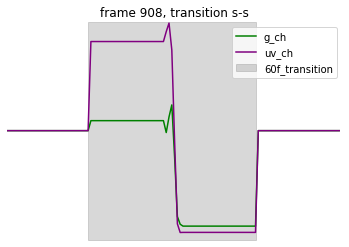

In [40]:
plt.plot(np.mean(output[frame_idx,tt_idx,0],axis=(-1,-2)),color='g',label='g_ch')
plt.plot(np.mean(output[frame_idx,tt_idx,1],axis=(-1,-2)),color='purple',label='uv_ch')
plt.fill_between((29,89),255,label='60f_transition',color='gray',alpha=0.3)
plt.axis('off')
plt.xlim((0,120))
plt.ylim((0,255))
plt.legend()
plt.title('frame {}, transition {}'.format(frame_idx,tt_dict[tt_idx]))

In [42]:
output.shape

(1000, 4, 2, 120, 18, 16)

#### UV-channel 2D graphic demo

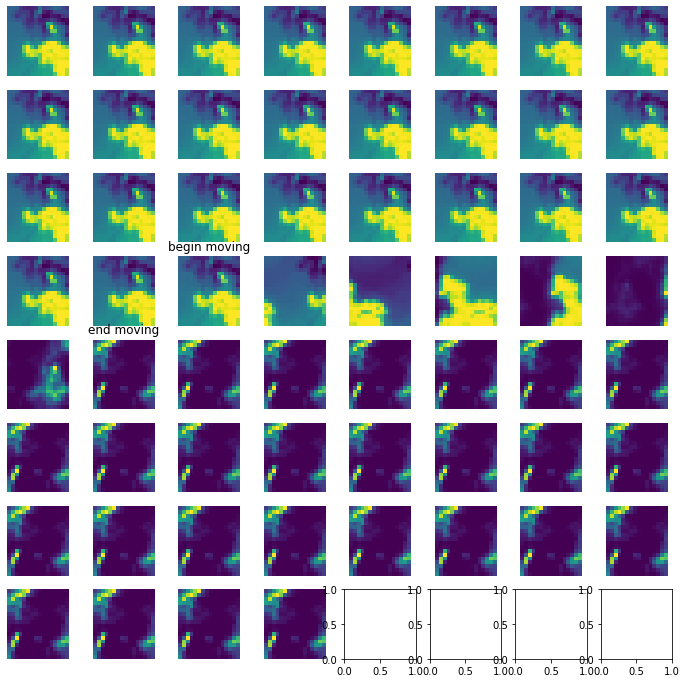

In [50]:
fig,ax = plt.subplots(8,8,figsize=(12,12))
ax = ax.flatten()
for ii in range(60):
    ax[ii].imshow(output[frame_idx,tt_idx,0,ii+30])
    ax[ii].axis('off')
    if ii == speed2embbedingidx[speed][0]:
        ax[ii].set_title('begin moving')
    elif ii == speed2embbedingidx[speed][0]+snippet_len-1:
        ax[ii].set_title('end moving')

In [51]:
output.shape

(1000, 4, 2, 120, 18, 16)